In [10]:
import matplotlib
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score


In [11]:
data=r"C:/Users/bolde/Desktop/School Work Spring 2020/Python_Data Mining/vcu-data-mining/data/winequality.csv"
df = pd.read_csv(data, encoding='ISO-8859-1')
df = df.drop(df.columns[0], axis=1)
sns.set(style='darkgrid')

## Q1. Predict whether a specific wine is of high quality or not

In [12]:
df.loc[df['wine type'] == 'White', 'wine_type'] = 1
df.loc[df['wine type'] == 'Red', 'wine_type'] = 0
df.loc[df['quality'] >= 8, 'high_quality'] = 1
df.loc[df['quality'] < 8, 'high_quality'] = 0
df['high_quality']=df['high_quality'].astype(int)
df['wine_type']=df['wine_type'].astype(int)

In [13]:
preds = df.columns[1:-1]
X = df[preds].drop(['wine type','quality'], axis=1)
y=df['high_quality']

## Q2. Split the data into two partitions (Train and Test) using 50/50 split

In [14]:
msk = np.random.rand(len(df)) <= 0.5
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]
# In[47]:
# target distribution in the trainig sample

y_train.value_counts()
# In[48]:
# target distribution in the test sample
y_test.value_counts()
# In[49]:

0    3206
1      99
Name: high_quality, dtype: int64

In [15]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Q3. Built a binary classification model using Gradient Boosting classifier & Hyperparameter

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbm = GradientBoostingClassifier(random_state=314)

param_grid = {'n_estimators': [50,100, 300, 500], 
              'learning_rate': [0.3,0.05, 0.1, 0.5 , 0.8],
              'max_depth': [3, 6,9,12],
              'min_samples_leaf': [0.01, 0.02, 0.05, 0.07]}



## Grid Search

In [17]:
gbm_gs = GridSearchCV(gbm, param_grid, cv=3, n_jobs=-1)

gbm_gs.fit(X_train, y_train) ## learning begins

print ('Best GBM Parameters:', gbm_gs.best_params_)

gbm_scores_train = gbm_gs.predict_proba(X_train)[:, 1]
gbm_scores_test = gbm_gs.predict_proba(X_test)[:, 1]

gbm_fpr_train, gbm_tpr_train, _ = roc_curve(y_train, gbm_scores_train)
gbm_fpr_test, gbm_tpr_test, _ = roc_curve(y_test, gbm_scores_test)

Best GBM Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 0.07, 'n_estimators': 100}


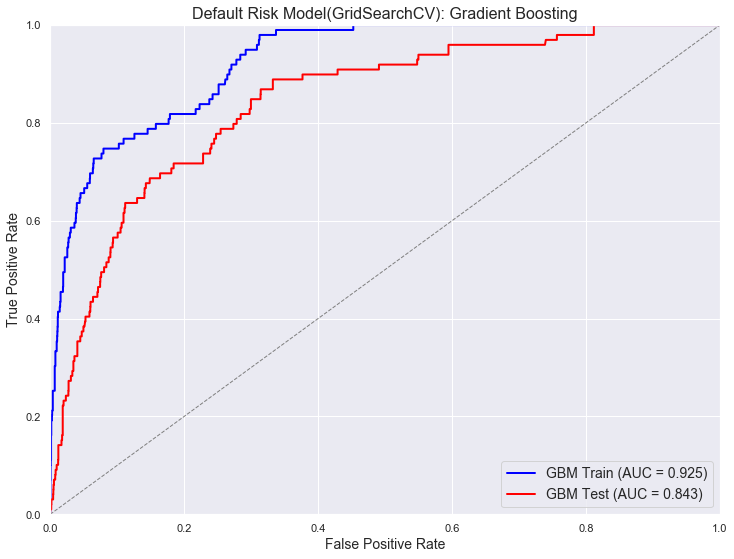

In [28]:
# ROC Curve
plt.figure().set_size_inches(12, 9)

plt.plot(gbm_fpr_train, gbm_tpr_train, color='blue', lw=2, alpha = 1, linestyle = '-',
         label=f'GBM Train (AUC = {roc_auc_score(y_train, gbm_scores_train):0.3f})')

plt.plot(gbm_fpr_test, gbm_tpr_test, color='red', lw=2, linestyle = '-',
         label=f'GBM Test (AUC = {roc_auc_score(y_test, gbm_scores_test):0.3f})')


plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model(GridSearchCV): Gradient Boosting', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
plt.show();

## Q4. Score the entire dataset using the final model

In [19]:
gbm_scores_full = gbm_gs.predict_proba(X)[:, 1]

In [20]:
Zdf=X[:]
Zdf['gbm_scores_full']=gbm_scores_full
Zdf['high_quality']=y
Zdf['decile'] = pd.qcut(Zdf['gbm_scores_full'].rank(ascending=False), 10, labels=False)+1
Zdf.loc[Zdf['gbm_scores_full'] >= .5, 'predicted_class_1'] = 1
Zdf.loc[Zdf['gbm_scores_full'] <  .5, 'predicted_class_1'] = 0
Zdf.loc[Zdf['gbm_scores_full'] >= .5, 'predicted_class_0'] = 0
Zdf.loc[Zdf['gbm_scores_full'] <  .5, 'predicted_class_0'] = 1

C:\Users\bolde\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bolde\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bolde\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [21]:
ddf=Zdf.groupby('decile').agg({
  'gbm_scores_full': ['min', 'max', 'count'
                      , 'mean'                     
                     ],
  'predicted_class_1':sum,
  'high_quality':sum
    
    
})
ddf.columns=['min', 'max', 'count'
                      , 'mean' ,'predicted_class_1' ,'high_quality'       
                     ]
fdf=ddf.reset_index()
fdf['cent_pc']=fdf['predicted_class_1']/fdf['count']*100
fdf['cent_hq']=fdf['high_quality']/fdf['count']*100
fdf['cent_hq_w']=fdf['high_quality']/sum(fdf['high_quality'])*100
fdf['lift']=fdf['cent_hq']/fdf['cent_hq_w']
del Zdf

In [22]:
fdf

,decile,min,max,count,mean,predicted_class_1,high_quality,cent_pc,cent_hq,cent_hq_w,lift
0,1,0.092085,0.418613,650,0.147209,0.0,125,0.0,19.230769,63.131313,0.304615
1,2,0.047236,0.091934,650,0.066934,0.0,25,0.0,3.846154,12.626263,0.304615
2,3,0.026937,0.047210,649,0.035749,0.0,22,0.0,3.389831,11.111111,0.305085
3,4,0.017755,0.026927,650,0.021827,0.0,15,0.0,2.307692,7.575758,0.304615
4,5,0.011782,0.017751,650,0.014555,0.0,2,0.0,0.307692,1.010101,0.304615
5,6,0.008033,0.011773,649,0.009794,0.0,3,0.0,0.462250,1.515152,0.305085
6,7,0.005459,0.008018,652,0.006600,0.0,2,0.0,0.306748,1.010101,0.303681
7,8,0.003945,0.005458,647,0.004617,0.0,2,0.0,0.309119,1.010101,0.306028
8,9,0.002822,0.003944,650,0.003388,0.0,2,0.0,0.307692,1.010101,0.304615
9,10,0.001468,0.002820,650,0.002301,0.0,0,0.0,0.000000,0.000000,NaN
